<a href="https://colab.research.google.com/github/Rama389/AI-Projects/blob/main/Supervised_Learning_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perceptron vs. Logistic Regression

Loading data from tmnst Dataset.csv...
Original data shape: (74724, 784)
Original labels shape: (74724,)
Cleaned data shape: (74724, 784)
Cleaned labels shape: (74724,)
Train data shape before LDA: (52306, 784)
Test data shape before LDA: (22418, 784)

Applying Fisher's LDA to reduce dimensions to 25...
Train data shape after LDA: (52306, 25)
Test data shape after LDA: (22418, 25)

Filtering data for classes A and C...
Binary train data shape: (4024, 25)
Binary test data shape: (1724, 25)

--- Running Perceptron Model Sweep for classes A_C (100 runs) ---

perceptron_A_C.csv generated successfully.
Perceptron Average Train Accuracy (100 runs): 0.9954
Perceptron Average Test Accuracy (100 runs): 0.9909


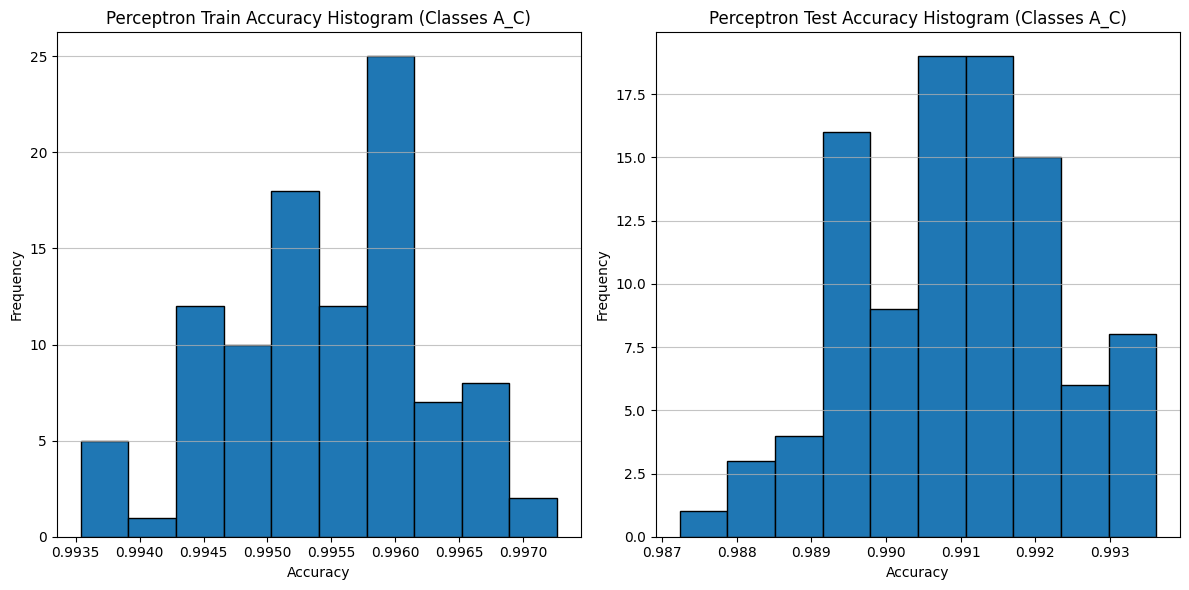

'Perceptron_Accuracy_Histograms_A_C.png' generated successfully.

--- Running Logistic Regression Model Sweep for classes A_C (100 runs) ---

logistic_A_C.csv generated successfully.
Logistic Regression Average Train Accuracy (100 runs): 0.9965
Logistic Regression Average Test Accuracy (100 runs): 0.9919


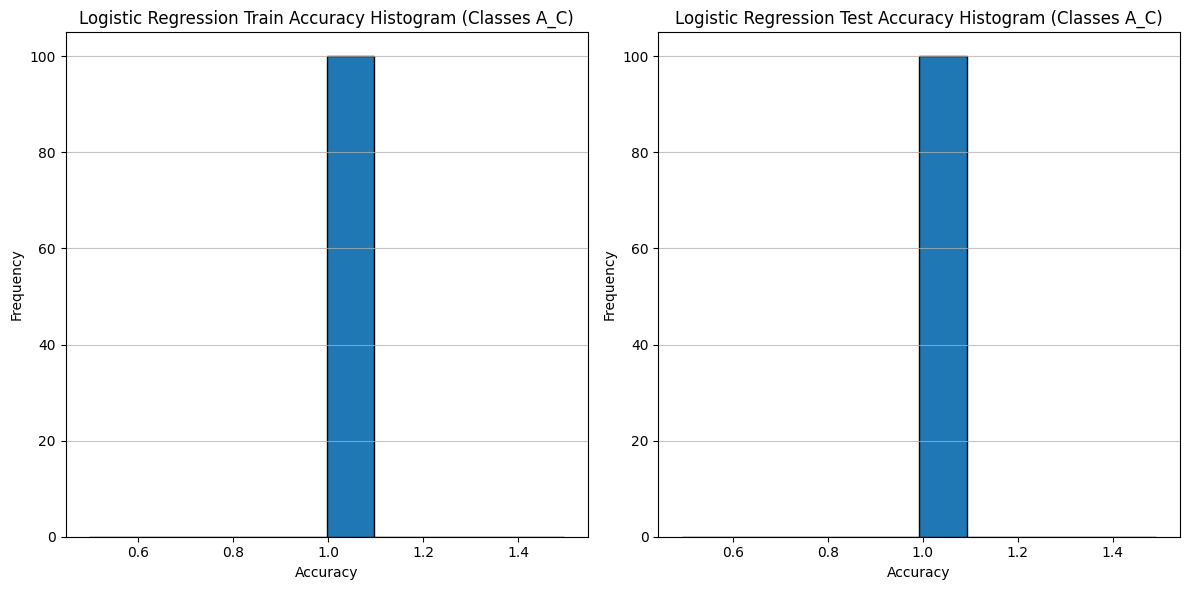

'Logistic_Accuracy_Histograms_A_C.png' generated successfully.

--- All Binary Classification Sweeps Completed ---
Check the generated CSV files and PNG plots for classes A and C.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed # New import for parallel processing

# --- Configuration ---
DATA_FILE = 'tmnst Dataset.csv' # Your data file name
TEST_SIZE = 0.3       # 30% for testing, 80% for training
RANDOM_STATE_GLOBAL = 42 # For reproducibility of initial data split and LDA
NUM_RUNS = 100        # Number of random initializations for models

# Define the two classes you want to pick for binary classification
# IMPORTANT: Adjust these if your actual class labels are different (e.g., 'A', 'C' if they are strings)
CLASS_1_LABEL = 'A'
CLASS_2_LABEL = 'C'

# --- 1. Data Loading and Preprocessing (Re-using previous steps) ---
print(f"Loading data from {DATA_FILE}...")
try:
    data = pd.read_csv(DATA_FILE, header=None, skiprows=1)
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE}' was not found. Please ensure it's in the same directory.")
    exit()

X = data.iloc[:, 1:].values  # Features (all columns except the first)
y = data.iloc[:, 0].values   # Labels (first column)

print(f"Original data shape: {X.shape}")
print(f"Original labels shape: {y.shape}")

# Identify and remove rows with NaN in labels
nan_rows = pd.isnull(y)
if np.any(nan_rows):
    print(f"Warning: Found {np.sum(nan_rows)} rows with NaN values in the label column. Removing these rows.")
    X = X[~nan_rows]
    y = y[~nan_rows]

print(f"Cleaned data shape: {X.shape}")
print(f"Cleaned labels shape: {y.shape}")

# Identify and remove classes with only one sample
unique_classes, class_counts = np.unique(y, return_counts=True)
classes_to_keep = unique_classes[class_counts >= 2]
indices_to_keep = np.isin(y, classes_to_keep)

if len(unique_classes) != len(classes_to_keep):
    removed_classes = set(unique_classes) - set(classes_to_keep)
    print(f"Warning: Removing classes with only one sample: {removed_classes}")
    X = X[indices_to_keep]
    y = y[indices_to_keep]
    print(f"Data shape after removing single-sample classes: {X.shape}")
    print(f"Labels shape after removing single-sample classes: {y.shape}")

# Split data into training and testing sets
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE_GLOBAL, stratify=y
)

print(f"Train data shape before LDA: {X_train_orig.shape}")
print(f"Test data shape before LDA: {X_test_orig.shape}")

# --- 2. Dimensionality Reduction using Fisher's LDA (Re-using previous steps) ---
print("\nApplying Fisher's LDA to reduce dimensions to 25...")
unique_classes_train = np.unique(y_train)
n_classes_train = len(unique_classes_train)
n_components_lda = min(25, n_classes_train - 1)

if n_components_lda < 25:
    print(f"Warning: Number of unique classes in training data ({n_classes_train}) is less than 26. LDA will reduce to {n_components_lda} dimensions.")

lda = LinearDiscriminantAnalysis(n_components=n_components_lda)

X_train_lda = lda.fit_transform(X_train_orig, y_train)
X_test_lda = lda.transform(X_test_orig)

print(f"Train data shape after LDA: {X_train_lda.shape}")
print(f"Test data shape after LDA: {X_test_lda.shape}")


# --- 3. Filter Data for Two Classes ---
print(f"\nFiltering data for classes {CLASS_1_LABEL} and {CLASS_2_LABEL}...")

# Create masks to select data points belonging to the chosen classes
train_mask = np.isin(y_train, [CLASS_1_LABEL, CLASS_2_LABEL])
test_mask = np.isin(y_test, [CLASS_1_LABEL, CLASS_2_LABEL])

# Apply masks to filter features and labels
X_train_binary = X_train_lda[train_mask]
y_train_binary = y_train[train_mask]
X_test_binary = X_test_lda[test_mask]
y_test_binary = y_test[test_mask]

# Remap labels to 0 and 1 for binary classification consistency
# CLASS_1_LABEL will be mapped to 0, CLASS_2_LABEL will be mapped to 1
y_train_binary_mapped = np.where(y_train_binary == CLASS_1_LABEL, 0, 1)
y_test_binary_mapped = np.where(y_test_binary == CLASS_1_LABEL, 0, 1)

print(f"Binary train data shape: {X_train_binary.shape}")
print(f"Binary test data shape: {X_test_binary.shape}")

# --- Helper Function for Perceptron (for parallel execution) ---
def _train_and_evaluate_perceptron(run_idx, train_features, train_labels, test_features, test_labels):
    """Helper function to train and evaluate a single Perceptron model."""
    perceptron = Perceptron(random_state=run_idx, max_iter=1000, tol=1e-3)
    perceptron.fit(train_features, train_labels)

    y_train_pred = perceptron.predict(train_features)
    train_accuracy = accuracy_score(train_labels, y_train_pred)

    y_test_pred = perceptron.predict(test_features)
    test_accuracy = accuracy_score(test_labels, y_test_pred)
    return {'run': run_idx + 1, 'train-accuracy': train_accuracy, 'test-accuracy': test_accuracy}

# --- 4. Perceptron Model Sweep Function ---
def perceptron_model(train, test, classes): # Function definition unchanged
    """
    Trains multiple Perceptron models with random initializations and records accuracies.

    Args:
        train (tuple): Tuple of (train_features, train_labels) for the binary classification.
        test (tuple): Tuple of (test_features, test_labels) for the binary classification.
        classes (list): List of the two class labels (e.g., ['A', 'C']) for naming.

    Returns:
        pd.DataFrame: DataFrame containing run number, train accuracy, and test accuracy.
    """
    train_features, train_labels = train
    test_features, test_labels = test
    class_labels_str = f"{classes[0]}_{classes[1]}" # Construct string from classes list

    print(f"\n--- Running Perceptron Model Sweep for classes {class_labels_str} ({NUM_RUNS} runs) ---")

    # Use joblib to parallelize the execution of multiple Perceptron training runs
    # n_jobs=-1 means use all available CPU cores
    results = Parallel(n_jobs=-1)(
        delayed(_train_and_evaluate_perceptron)(i, train_features, train_labels, test_features, test_labels)
        for i in range(NUM_RUNS)
    )

    df_results = pd.DataFrame(results)
    filename = f'perceptron_{class_labels_str}.csv'
    df_results.to_csv(filename, index=False)
    print(f"\n{filename} generated successfully.")

    # Compute and print average accuracies
    avg_train_acc = df_results['train-accuracy'].mean()
    avg_test_acc = df_results['test-accuracy'].mean()
    print(f"Perceptron Average Train Accuracy ({NUM_RUNS} runs): {avg_train_acc:.4f}")
    print(f"Perceptron Average Test Accuracy ({NUM_RUNS} runs): {avg_test_acc:.4f}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df_results['train-accuracy'], bins=10, edgecolor='black')
    plt.title(f'Perceptron Train Accuracy Histogram (Classes {class_labels_str})')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(1, 2, 2)
    plt.hist(df_results['test-accuracy'], bins=10, edgecolor='black')
    plt.title(f'Perceptron Test Accuracy Histogram (Classes {class_labels_str})')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plot_filename = f'Perceptron_Accuracy_Histograms_{class_labels_str}.png'
    plt.savefig(plot_filename)
    plt.show()
    print(f"'{plot_filename}' generated successfully.")

    return df_results

# --- Helper Function for Logistic Regression (for parallel execution) ---
def _train_and_evaluate_logistic(run_idx, train_features, train_labels, test_features, test_labels):
    """Helper function to train and evaluate a single Logistic Regression model."""
    logistic_reg = LogisticRegression(random_state=run_idx, solver='liblinear', max_iter=1000)
    logistic_reg.fit(train_features, train_labels)

    y_train_pred = logistic_reg.predict(train_features)
    train_accuracy = accuracy_score(train_labels, y_train_pred)

    y_test_pred = logistic_reg.predict(test_features)
    test_accuracy = accuracy_score(test_labels, y_test_pred)
    return {'run': run_idx + 1, 'train-accuracy': train_accuracy, 'test-accuracy': test_accuracy}

# --- 5. Logistic Regression Model Sweep Function ---
def logistic_model(train, test, classes): # Function definition unchanged
    """
    Trains multiple Logistic Regression models with random initializations and records accuracies.

    Args:
        train (tuple): Tuple of (train_features, train_labels) for the binary classification.
        test (tuple): Tuple of (test_features, test_labels) for the binary classification.
        classes (list): List of the two class labels (e.g., ['A', 'C']) for naming.

    Returns:
        pd.DataFrame: DataFrame containing run number, train accuracy, and test accuracy.
    """
    train_features, train_labels = train
    test_features, test_labels = test
    class_labels_str = f"{classes[0]}_{classes[1]}" # Construct string from classes list

    print(f"\n--- Running Logistic Regression Model Sweep for classes {class_labels_str} ({NUM_RUNS} runs) ---")

    # Use joblib to parallelize the execution of multiple Logistic Regression training runs
    results = Parallel(n_jobs=-1)(
        delayed(_train_and_evaluate_logistic)(i, train_features, train_labels, test_features, test_labels)
        for i in range(NUM_RUNS)
    )

    df_results = pd.DataFrame(results)
    filename = f'logistic_{class_labels_str}.csv'
    df_results.to_csv(filename, index=False)
    print(f"\n{filename} generated successfully.")

    # Compute and print average accuracies
    avg_train_acc = df_results['train-accuracy'].mean()
    avg_test_acc = df_results['test-accuracy'].mean()
    print(f"Logistic Regression Average Train Accuracy ({NUM_RUNS} runs): {avg_train_acc:.4f}")
    print(f"Logistic Regression Average Test Accuracy ({NUM_RUNS} runs): {avg_test_acc:.4f}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df_results['train-accuracy'], bins=10, edgecolor='black')
    plt.title(f'Logistic Regression Train Accuracy Histogram (Classes {class_labels_str})')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(1, 2, 2)
    plt.hist(df_results['test-accuracy'], bins=10, edgecolor='black')
    plt.title(f'Logistic Regression Test Accuracy Histogram (Classes {class_labels_str})')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plot_filename = f'Logistic_Accuracy_Histograms_{class_labels_str}.png'
    plt.savefig(plot_filename)
    plt.show()
    print(f"'{plot_filename}' generated successfully.")

    return df_results

# --- Main Execution ---

# String representation of the chosen classes for filenames and plot titles
# This is derived from the global CLASS_1_LABEL and CLASS_2_LABEL
classes_for_functions = [CLASS_1_LABEL, CLASS_2_LABEL]

# Prepare data for the functions as tuples (features, labels)
train_data_tuple = (X_train_binary, y_train_binary_mapped)
test_data_tuple = (X_test_binary, y_test_binary_mapped)


# Perform Perceptron sweep
perceptron_results_df = perceptron_model(
    train_data_tuple,
    test_data_tuple,
    classes_for_functions
)

# Perform Logistic Regression sweep
logistic_results_df = logistic_model(
    train_data_tuple,
    test_data_tuple,
    classes_for_functions
)

print("\n--- All Binary Classification Sweeps Completed ---")
print(f"Check the generated CSV files and PNG plots for classes {CLASS_1_LABEL} and {CLASS_2_LABEL}.")

**Comment**: Perceptron objective is to find any seperating plane and based on that it seperates the data points and classifies thus there are many bars present in perceptron histogram and for logistic classification it is log function and uses one global function.
Accuarcy is good for both the approaches.